# Example of Kalman Filter decoders

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing is different for the Kalman, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import KalmanFilterDecoder

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


## 2. Load Data

The data that we load is in the format described below. We have another example script, "neural_preprocessing.py" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [17]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
# folder='/Users/jig289/Dropbox/Grad_School/Research/Projects/In_Progress/Decoding/DataFiles/'
folder='/home/jglaser2/Data/DecData/'

with open(folder+'s1_test_data.pickle','rb') as f:
    neural_data,vels_binned,pos_binned,acc_binned=pickle.load(f)

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [18]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### 3B. Format Covariates

#### Format Input

In [19]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data

#### Format Output

In [20]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine position
pos_binned=np.zeros(vels_binned.shape) #Initialize 
pos_binned[0,:]=0 #Assume starting position is at [0,0]
#Loop through time bins and determine positions based on the velocities
for i in range(pos_binned.shape[0]-1): 
    pos_binned[i+1,0]=pos_binned[i,0]+vels_binned[i,0]*.05 #Note that .05 is the length of the time bin
    pos_binned[i+1,1]=pos_binned[i,1]+vels_binned[i,1]*.05

#We will now determine acceleration    
temp=np.diff(vels_binned,axis=0) #The acceleration is the difference in velocities across time bins 
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

#The final output covariates include position, velocity, and acceleration
y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

### 3C. Process Covariates

#### Normalization and zero-centering

In [21]:
#Z-scoring function that works with Nans:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [22]:
#Normalize inputs
X_kf=zscore_nan(X_kf,axis=0)

#Zero-center outputs
y_kf_mean=np.mean(y_kf,axis=0)
y_kf=y_kf-y_kf_mean

#### Take lag into account

In [23]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [24]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0.1, 0.5]
testing_range=[0.7, 0.85]
valid_range=[0,.1]

### Split Data: For KF

In [25]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

## 4. Run Decoder
Note that in this example, we are evaluating the model fit on the validation set

### Kalman Filter

In [26]:
#Declare model
model_kf=KalmanFilterDecoder()

#Fit model
model_kf.fit(X_kf_train,y_kf_train)

#Get predictions
y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

#Get metrics of fit (see read me for more details on the differences between metrics)
#First I'll get the R^2
R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
print('R2:',R2_kf[2:4]) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities
#Next I'll get the rho^2 (the pearson correlation squared)
rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
print('rho2:',rho_kf[2:4]**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities

('R2:', array([ 0.67430789,  0.67028978]))
('rho2:', array([ 0.68240801,  0.68527343]))


In [ ]:
M1
-3: ('R2:', array([ 0.71765297,  0.77715408]))
-2: ('R2:', array([ 0.75753484,  0.8113673 ]))
-1: ('R2:', array([ 0.75975892,  0.8055996 ]))

In [ ]:
S1
-1: 0.61267287,  0.56021309
0: 0.67430789,  0.67028978

## 5. Make Plots

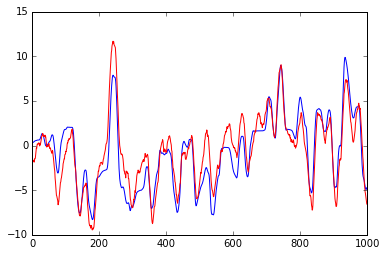

In [13]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[1000:2000,0]+y_kf_mean[0],'b')
plt.plot(y_valid_predicted_kf[1000:2000,0]+y_kf_mean[0],'r')
#Save figure
# fig_x_kf.savefig('x_velocity_decoding.eps')